# Import libraries

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
from numpy.random import default_rng
rng = default_rng()
import torch 
import torch.nn as nn
from scipy.stats import norm
from tqdm import trange, tqdm
from torch import Tensor 
from typing import Optional
from math import ceil
from functools import partial
from scipy.integrate import quad
import pickle
import pandas as pd
from matplotlib import rcParams
#from google.colab import drive
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import plotly.figure_factory as ff


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
plt.style.use('ggplot')
rcParams["figure.figsize"]  = (16,9)

### Lexique


* `[Warning]` : This message is to tell the user that there is no need to run the following cell after the warning message in red ( you will see the message by scrooling down the .ipynb) because it grows the memory space of the .ipynb "Deep_Hedging" due to the plot that consumes space. For instance with just 6 plots we went from 1.13 KB to 600 MB that causes crash of the notebook and slowed the execution. However you can few of them to see the result of the plot but keep in mind if the .ipynb starting to be slow clear the outputs of the cell you ran and everything will be fine. 
  

# List of colors from plotly

In [4]:
list_of_colors = [
    '#EB89B5',
    '#330C73',
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

# 1 . Under Black scholes

In [14]:
# Parameters
r = 0.1
sigma = 0.25
x0 = 100.
K = 100.
N, T = 10, 1

## Paths simulation

In [15]:
def simu_S(N, M): 
    h = T/N
    brown_acc = np.sqrt(h)*rng.standard_normal(size=(N, M))
    sample = np.zeros(shape=(N+1, M))
    sample[0] = x0
    for n in range(1, N+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    return sample

In [16]:
N, M = 10, 2**20
sample = simu_S(N, M)
sample_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * sample

## Data preprocessing

In [17]:
L = 2*x0
data_size = M
xj_path = torch.from_numpy(sample_act).to(device).float().T / L
zj = torch.from_numpy(np.exp(-r*T)*np.maximum(sample[N]-K, 0))[:,None].to(device).float() / L

## PnL modelling

In [18]:
def pnl_BS(xj_path, zj, phi,is_reccurent=False,with_tc=False,prop=True,c=0): 
  """_This function calculate the PNL under Black Scholes_
  Args:
      xj_path (_array_): _array of shape (M,N+1) representing the stock price_
      zj (_array_): _array of shape (M,1) representing the final payoff_
      phi (_function_): _function that takes an integer n and a tensor of shape (M,1) representing the stock price at time n and returns the option price and the option delta at time n_
      is_reccurent (_boolean_): _specifies wether the phi function is reccurent (uses the previous hedge to estimate the present hedge)
      with_tc (bool, optional): _indicates whether or not transaction costs should be included_. Defaults to False.
      prop (bool, optional): _specifies whether the transacion costs are proportional or fixed_. Defaults to True.
      c (int, optional): _transaction cost rate in %_. Defaults to 0.

  Returns:
      _array_: _array of shape (M,1) representing the pnl of the option_
  """
  value = np.zeros_like(xj_path[:,[0]])
  delta = []
  p0, delta0 = phi(0, xj_path[:,[0]])
  delta.append(delta0)
  value = p0 - delta0 * xj_path[:,[0]]
  for n in range(1,N):
      if is_reccurent == False:
        delta.append(phi(n, xj_path[:,[n]]))
      else: 
        delta.append(phi(n, xj_path))
      if with_tc== True : 
        if prop == True : 
          value = value - ((delta[n] - delta[n-1]) * xj_path[:,[n]]) - (abs(delta[n]-delta[n-1])*(c/100)*xj_path[:,[n]])
        else:
          value = value - ((delta[n] - delta[n-1]) * xj_path[:,[n]]) - (abs(delta[n]-delta[n-1])*(c/100))
      else:
        value = value - (delta[n] - delta[n-1]) * xj_path[:,[n]]       
  value = value + delta[N-1] * xj_path[:,[N]] - zj
  return value * np.exp(r*T)

## Model Hedge 

In [19]:
# Exact solution
def d1(spot, t, r=r, sigma=sigma, strike=K):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

def d2(spot, t, r=r, sigma=sigma, strike=K):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

def price_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)

def dprice_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    return norm.cdf(d1(spot, t, r, sigma, strike))

In [20]:
P0e = price_call_BS(x0, T, r, sigma, K)
def bs_hedge(n, xn):
    if n == 0: 
        return P0e/L, torch.from_numpy(dprice_call_BS(L*xn, T)).to(device).float()
    return torch.from_numpy(dprice_call_BS(L*np.exp(r*n*T/N)*xn.detach().numpy(), 
                                           (N-n)*T/N)).to(device).float()

In [21]:
pnl_bs = L * pnl_BS(xj_path, zj, bs_hedge).detach().numpy().flatten()
pnl_bs_tc = L * pnl_BS(xj_path, zj, bs_hedge,with_tc=True,prop=True,c=0.01).detach().numpy().flatten()

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
x0 = pnl_bs


fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='Model hedge', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color='#EB89B5',
    opacity=0.75
))



fig.update_layout(
    width = 1000,
    height = 500,
    title_text='Model Hedge', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

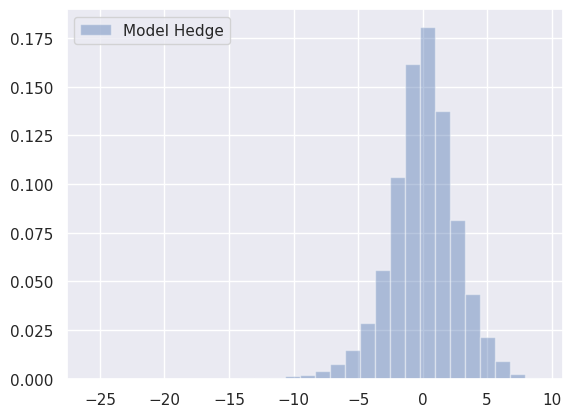

In [ ]:
fig, ax = plt.subplots()
ax.hist(pnl_bs, bins=30, density=True, alpha=0.4, label="Model Hedge")
ax.legend()
plt.show()

## Neural Network Hedge 

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size):
        super().__init__()
        layers = [ nn.Linear(input_size, layer_sizes[0]),
                   nn.ReLU() ]
        for (ls_in, ls_out) in zip(layer_sizes, layer_sizes[1:]):
            layers.append(nn.Linear(ls_in, ls_out))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-1], output_size))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

### FFNN 

In [23]:
class FFNN_hedge(nn.Module):
    def __init__(self, N, input_size, layer_sizes, output_size):
        super().__init__()
        self.price_p0 = nn.Parameter(torch.ones(1))
        self.hedge_q0 = nn.Parameter(torch.ones(1))
        self.hedge_q = nn.ModuleList([
            NeuralNetwork(input_size, layer_sizes, output_size) for n in range(1,N) 
        ])
    def forward(self, n, x):
        if n == 0: 
            return self.price_p0, self.hedge_q0
        else:
            return self.hedge_q[n-1](x)

#### Model training

In [24]:
def learning_from_data(xj_path, zj, phi, n_epochs, batch_size,is_reccurent=False,criterion ='MSE', p=0.5,learning_rate=1e-3,with_tc=False,prop=True,c=0): 
  
  """_ calculates the loss based on the specified criterion (MSE or CVaR) for each epoch and for each batch 
     and updates the model's parameters with backpropagation using the optimizer. 
    The losses are recorded in a list, which is returned after all epochs have been completed._

    Args:
        xj_path (_array_): _array of shape (M,N+1) representing the stock price_
        zj (_array_): _array of shape (M,1) representing the final payoff_
        phi (_function_): _function that takes an integer n and a tensor of shape (M,1) representing the stock price at time n and returns the option price and the option delta at time n_
        is_reccurent (_boolean_): _specifies wether the phi function is reccurent (uses the previous hedge to estimate the present hedge)
        with_tc (bool, optional): _indicates whether or not transaction costs should be included_. Defaults to False.
        prop (bool, optional): _specifies whether the transacion costs are proportional or fixed_. Defaults to True.
        c (int, optional): _transaction cost rate in %_. Defaults to 0.
        n_epochs (_int_): _number of epochs_
        batch_size (_int_): _batch size_
        criterion (str, optional): _Function to minimize by the Neural Network: It can be MSE (Mean squared error) or CVaR (Expected shortfall of reverse P&L_. Defaults to 'MSE'.
        p (float, optional): _CVaR level_. Defaults to 0.5.
        learning_rate (_float_, optional): _learning rate_. Defaults to 1e-3.

    Returns:
        _list_: _Recorded losses_
    """
  data_size = zj.shape[0]
  n_upd = data_size // batch_size 
  optimizer = torch.optim.Adam(phi.parameters(), lr=learning_rate)
  losses = []
  with tqdm(range(n_epochs)) as nrange:
      for n in nrange:
          indexes = torch.randperm(data_size)   
          for k in range(n_upd):
              idx = indexes[k*batch_size:(k+1)*batch_size]
              if criterion == 'MSE': 
                loss = (pnl_BS(xj_path[[idx]], zj[[idx]], phi,is_reccurent,with_tc,prop,c)**2).mean()  
              if criterion == 'CVaR':
                pl = pnl_BS(xj_path[[idx]], zj[[idx]], phi,is_reccurent,with_tc,prop,c) 
                neg_pl=torch.abs(-pl)
                top_neg_pl=neg_pl.topk(ceil(p * neg_pl.size(dim=0)), dim=0, largest=True).values
                loss=top_neg_pl.mean(dim=0)                
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()  
              losses.append(loss.item())
          nrange.set_postfix(loss=loss.item())
  return losses

In [25]:
n_epochs = 32
batch_size = 2**12

In [26]:
##### To save time, you can load the saved models and ignore the next cell: all these models are in the "BS/FFNN/No transaction costs"
# No transaction costs models
root_bs_no_costs = "Models/BS/FFNN/No transaction costs/"
phi_MSE_Notc=FFNN_hedge(N, 1, [16, 16, 16],1)
phi_MSE_Notc.load_state_dict(torch.load(root_bs_no_costs+"BS_FFNN_MSE_Notc.pth")) 
phi_CVaR_50_Notc=FFNN_hedge(N, 1, [16, 16, 16],1)
phi_CVaR_50_Notc.load_state_dict(torch.load(root_bs_no_costs+"BS_FFNN_CVaR_50_Notc.pth"))
phi_CVaR_99_Notc=FFNN_hedge(N, 1, [16, 16, 16],1)
phi_CVaR_99_Notc.load_state_dict(torch.load(root_bs_no_costs+"BS_FFNN_CVaR_99_Notc.pth"))

<All keys matched successfully>

In [ ]:
# No transaction costs: Models training
## MSE
phi_MSE_Notc=FFNN_hedge(N, 1, [16, 16, 16],1)
losses_MSE_Notc= learning_from_data(xj_path, zj, phi_MSE_Notc, n_epochs, batch_size)
## CVaR 50% 
phi_CVaR_50_Notc=FFNN_hedge(N, 1, [16, 16, 16],1)
#p=0.5
losses_CVaR_50_Notc= learning_from_data(xj_path, zj, phi_CVaR_50_Notc, n_epochs, batch_size,criterion='CVaR',p=0.5)
## CVaR 99% 
phi_CVaR_99_Notc=FFNN_hedge(N, 1, [16, 16, 16],1)
#p=0.01
losses_CVaR_99_Notc= learning_from_data(xj_path, zj, phi_CVaR_99_Notc, n_epochs, batch_size,criterion='CVaR',p=0.01)

In [ ]:
# Save models 
#torch.save(phi_MSE_Notc.state_dict(),"BS_FFNN_MSE_Notc.pth")
#torch.save(phi_CVaR_50_Notc.state_dict(),"BS_FFNN_CVaR_50_Notc.pth")
#torch.save(phi_CVaR_99_Notc.state_dict(),"BS_FFNN_CVaR_99_Notc.pth")

In [27]:
pnl_FNN_MSE_Notc= L*pnl_BS(xj_path, zj, phi_MSE_Notc).detach().numpy().flatten()
pnl_FNN_CVaR_50_Notc = L*pnl_BS(xj_path, zj, phi_CVaR_50_Notc).detach().numpy().flatten()
pnl_FNN_CVaR_99_Notc= L*pnl_BS(xj_path, zj, phi_CVaR_99_Notc).detach().numpy().flatten()

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x0 = pnl_bs
x1 = pnl_FNN_MSE_Notc
x2 = pnl_FNN_CVaR_50_Notc
x3 = pnl_FNN_CVaR_99_Notc

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='Model hedge', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[0] ,
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x1,
    histnorm='percent',
    name='FFNN hedging- MSE', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[1],
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x2,
    histnorm='percent',
    name='FFNN hedging- 50% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[2],
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x3,
    histnorm='percent',
    name='FFNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[3],
    opacity=0.75
))



fig.update_layout(
    width = 1000,
    height = 500,
    title_text='"Comparison of model hedge and deep hedge with different criterion without transaction costs', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.05, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

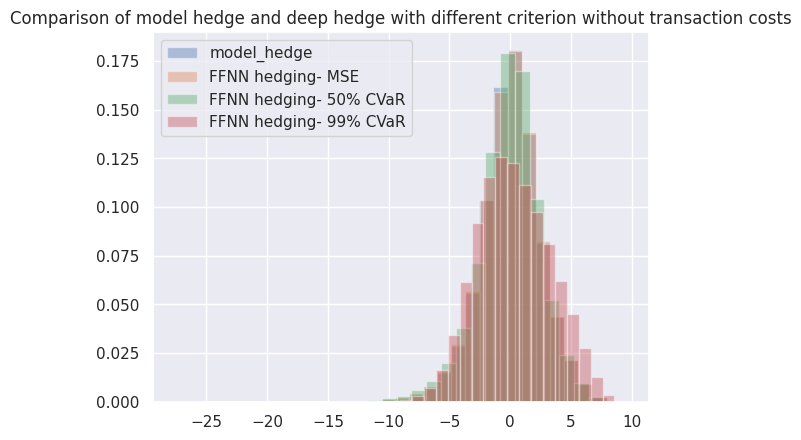

In [ ]:
bins=30
fig, ax = plt.subplots()
ax.hist(pnl_bs,bins=bins, density=True, alpha=0.4, label="model_hedge")
ax.hist(pnl_FNN_MSE_Notc,bins=bins, density=True, alpha=0.4, label="FFNN hedging- MSE")
ax.hist(pnl_FNN_CVaR_50_Notc,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 50% CVaR")
ax.hist(pnl_FNN_CVaR_99_Notc,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 99% CVaR")
ax.legend()
plt.title("Comparison of model hedge and deep hedge with different criterion without transaction costs")
plt.show()

In [ ]:
%%time 
xx = np.linspace(20, 180, 100)


fig = go.Figure()
fig.add_trace(go.scatter(
    x=x0,
    histnorm='percent',
    name='Model hedge', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color='#EB89B5',
    opacity=0.75
))



fig.update_layout(
    width = 1000,
    height = 500,
    title_text='Model Hedge', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

In [ ]:
%%time
xx = np.linspace(20, 150, M)
fig, ax = plt.subplots()
zz = dprice_call_BS(xx, T)
ax.scatter(xx, zz, s= 2, label="Delta Hedging BS")
for n in reversed(range(1,N)):
    with torch.no_grad():
        xx = L * xj_path[:, [n]].numpy()
        yy = phi_CVaR_50_Notc(n, xj_path[:,[n]]).numpy()
        ax.scatter(xx, yy, s=2, label=f"hedging at time {n}")
ax.legend()
plt.show()

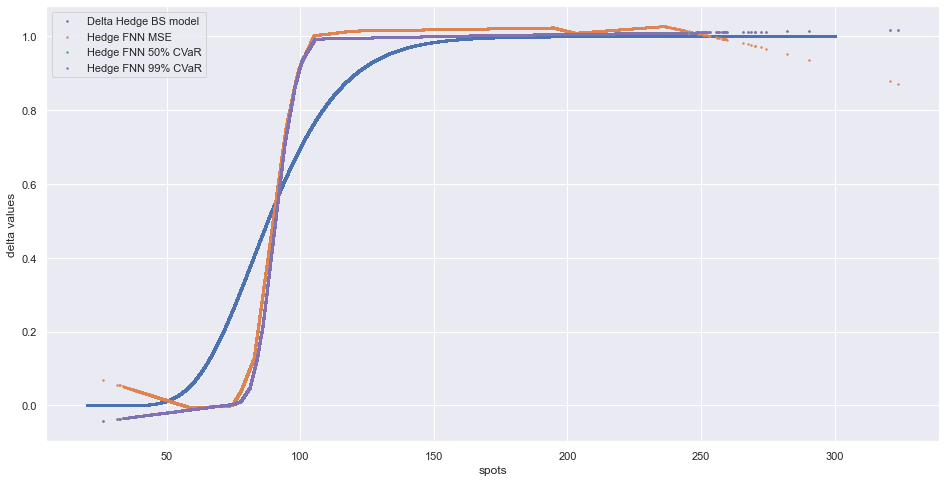

Wall time: 1min 5s


In [304]:
%%time 

xx = np.linspace(20,300,M)
fig, ax = plt.subplots(figsize =(16,8))
zz = dprice_call_BS(xx, T)
ax.scatter(xx, zz, s=2, label="Delta Hedge BS model", color='C0')

with torch.no_grad():
    xx = L * xj_path[:, [N-1]].numpy()
    x0 = phi_MSE_Notc(N-1, xj_path[:,[N-1]])
    x1 = phi_CVaR_50_Notc(N-1, xj_path[:,[N-1]])
    x2 = phi_CVaR_99_Notc(N-1, xj_path[:,[N-1]])
ax.scatter(xx, x0, s=2, label="Hedge FNN MSE", color='C1')
ax.scatter(xx, x1, s=2, label="Hedge FNN 50% CVaR", color='C2')
ax.scatter(xx, x1, s=2, label="Hedge FNN 99% CVaR", color='C4')

plt.title("Terminal time FNN Hedging vs BS Model Hedge for different risk measures")
ax.set_xlabel("spots")
ax.set_ylabel("delta values")
ax.legend(loc='best')
sns.set()
plt.show()

In [28]:
##### To save time, you can load the saved models and ignore the next cell: all these models are in the "BS/FFNN/prop transaction costs"
# with prop trans cost models
root_bs_costs = "Models/BS/FFNN/Prop trans costs/"
phi_MSE_tc=FFNN_hedge(N, 1, [16, 16, 16],1)
phi_MSE_tc.load_state_dict(torch.load(root_bs_costs+"BS_FFNN_MSE_tc.pth")) 
phi_CVaR_50_tc=FFNN_hedge(N, 1, [16, 16, 16],1)
phi_CVaR_50_tc.load_state_dict(torch.load(root_bs_costs+"BS_FFNN_CVaR_50_tc.pth"))
phi_CVaR_99_tc=FFNN_hedge(N, 1, [16, 16, 16],1)
phi_CVaR_99_tc.load_state_dict(torch.load(root_bs_costs+"BS_FFNN_CVaR_99_tc.pth"))

<All keys matched successfully>

In [30]:
# with prop transaction costs: Models training
with_tc= True
prop = True
c=0.01

In [ ]:
## MSE
phi_MSE_tc=FFNN_hedge(N, 1, [16, 16, 16],1)
losses_MSE_tc= learning_from_data(xj_path, zj, phi_MSE_tc, n_epochs, batch_size,with_tc=with_tc,prop=prop,c=c)
## CVaR 50% 
phi_CVaR_50_tc=FFNN_hedge(N, 1, [16, 16, 16],1)
#p=0.5
losses_CVaR_50_tc= learning_from_data(xj_path, zj, phi_CVaR_50_tc, n_epochs, batch_size,criterion='CVaR',p=0.5,with_tc=with_tc,prop=prop,c=c)
## CVaR 99% 
phi_CVaR_99_tc=FFNN_hedge(N, 1, [16, 16, 16],1)
#p=0.01
losses_CVaR_99_tc= learning_from_data(xj_path, zj, phi_CVaR_99_tc, n_epochs, batch_size,criterion='CVaR',p=0.01,with_tc=with_tc,prop=prop,c=c)

100%|██████████| 32/32 [02:24<00:00,  4.51s/it, loss=0.0391]


In [ ]:
# Save models 
#torch.save(phi_MSE_tc.state_dict(),"BS_FFNN_MSE_tc.pth")
#torch.save(phi_CVaR_50_tc.state_dict(),"BS_FFNN_CVaR_50_tc.pth")
#torch.save(phi_CVaR_99_tc.state_dict(),"BS_FFNN_CVaR_99_tc.pth")

In [31]:
pnl_FNN_MSE_tc= L*pnl_BS(xj_path, zj, phi_MSE_tc,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
pnl_FNN_CVaR_50_tc = L*pnl_BS(xj_path, zj, phi_CVaR_50_tc,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
pnl_FNN_CVaR_99_tc= L*pnl_BS(xj_path, zj, phi_CVaR_99_tc,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x0 = pnl_bs_tc
x1 = pnl_FNN_MSE_tc
x2 = pnl_FNN_CVaR_50_tc
x3 = pnl_FNN_CVaR_99_tc

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='Model hedge', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[0] ,
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x1,
    histnorm='percent',
    name='FFNN hedging- MSE', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[1],
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x2,
    histnorm='percent',
    name='FFNN hedging- 50% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[2],
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x3,
    histnorm='percent',
    name='FFNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[3],
    opacity=0.75
))



fig.update_layout(
    width = 1000,
    height = 500,
    title_text='Comparison of model hedge and deep hedge with different criterion with prop transaction costs: 0.01%', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.05, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

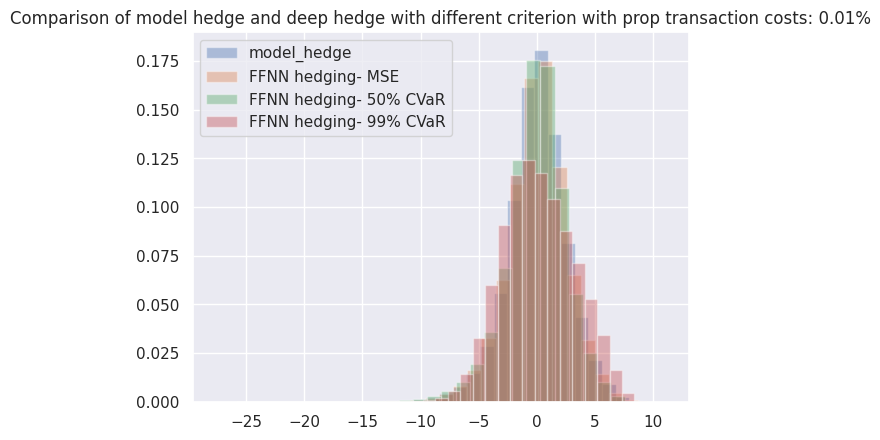

In [ ]:
bins=30
fig, ax = plt.subplots()
ax.hist(pnl_bs_tc,bins=bins, density=True, alpha=0.4, label="model_hedge")
ax.hist(pnl_FNN_MSE_tc,bins=bins, density=True, alpha=0.4, label="FFNN hedging- MSE")
ax.hist(pnl_FNN_CVaR_50_tc,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 50% CVaR")
ax.hist(pnl_FNN_CVaR_99_tc,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 99% CVaR")
ax.legend()
plt.title("Comparison of model hedge and deep hedge with different criterion with prop transaction costs: 0.01%")
plt.show()

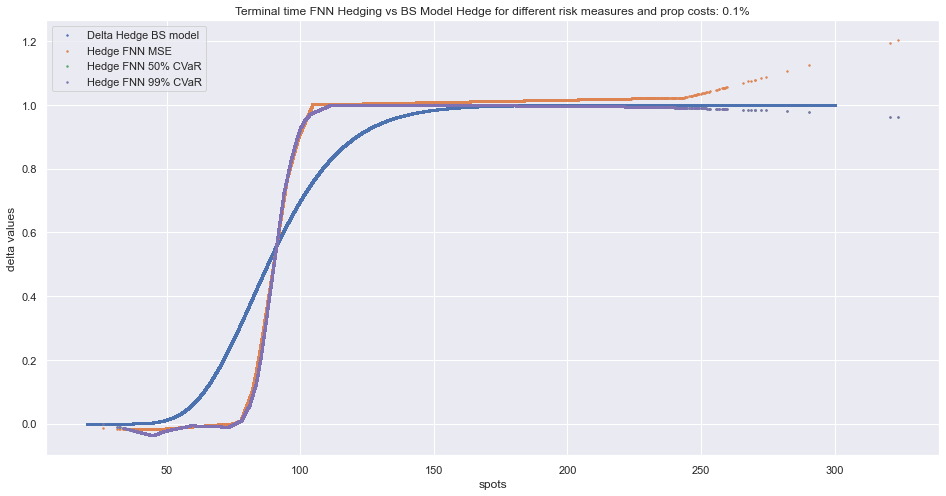

Wall time: 1min 6s


In [306]:
%%time 

xx = np.linspace(20,300,M)
fig, ax = plt.subplots(figsize =(16,8))
zz = dprice_call_BS(xx, T)
ax.scatter(xx, zz, s=2, label="Delta Hedge BS model", color='C0')

with torch.no_grad():
    xx = L * xj_path[:, [N-1]].numpy()
    x0 = phi_MSE_tc(N-1, xj_path[:,[N-1]])
    x1 = phi_CVaR_50_tc(N-1, xj_path[:,[N-1]])
    x2 = phi_CVaR_99_tc(N-1, xj_path[:,[N-1]])
ax.scatter(xx, x0, s=2, label="Hedge FNN MSE", color='C1')
ax.scatter(xx, x1, s=2, label="Hedge FNN 50% CVaR", color='C2')
ax.scatter(xx, x1, s=2, label="Hedge FNN 99% CVaR", color='C4')

plt.title("Terminal time FNN Hedging vs BS Model Hedge for different risk measures and prop costs: 0.1%")
ax.set_xlabel("spots")
ax.set_ylabel("delta values")
ax.legend(loc='best')
sns.set()
plt.show()

#### Model testing

In [32]:
# Testing on new data
def simu_data(batch_size, device=device):
    h = T/N
    brown_acc = np.sqrt(h)*torch.randn(size=(N, batch_size), device=device)
    sample_act = torch.zeros(size=(N+1, batch_size))
    sample_act[0] = x0
    for n in range(1, N+1):
        sample_act[n] = sample_act[n-1] * torch.exp((- 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    xj_path = (sample_act / L).T
    
    zj = (np.exp(-r*T) * torch.relu(np.exp(r*T) * sample_act[N] - K) / L)[:,None]
    return xj_path, zj

In [33]:
test_size = 2**12
xj_test, zj_test = simu_data(test_size)

with torch.no_grad():
    pnl_bs_Notc_test = L*pnl_BS(xj_test, zj_test, bs_hedge).detach().numpy().flatten()
    pnl_FNN_MSE_Notc_test = L*pnl_BS(xj_test, zj_test, phi_MSE_Notc).detach().numpy().flatten()
    pnl_FNN_CVaR_50_Notc_test = L*pnl_BS(xj_test, zj_test, phi_CVaR_50_Notc).detach().numpy().flatten()
    pnl_FNN_CVaR_99_Notc_test = L*pnl_BS(xj_test, zj_test, phi_CVaR_99_Notc).detach().numpy().flatten()
    pnl_bs_tc_test = L*pnl_BS(xj_test, zj_test, bs_hedge,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
    pnl_FNN_MSE_tc_test = L*pnl_BS(xj_test, zj_test, phi_MSE_tc,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
    pnl_FNN_CVaR_50_tc_test = L*pnl_BS(xj_test, zj_test, phi_CVaR_50_tc,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
    pnl_FNN_CVaR_99_tc_test = L*pnl_BS(xj_test, zj_test, phi_CVaR_99_tc,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
    

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x10 = pnl_bs_Notc_test
x11 = pnl_FNN_MSE_Notc_test
x12 = pnl_FNN_CVaR_50_Notc_test
x13 = pnl_FNN_CVaR_99_Notc_test

x20 = pnl_bs_tc_test
x21 = pnl_FNN_MSE_tc_test
x22 = pnl_FNN_CVaR_50_tc_test
x23 = pnl_FNN_CVaR_99_tc_test

fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Histogram(
    x=x10,
    histnorm='percent',
    name='Model hedge', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[0] ,
    opacity=0.75),
    row = 1,
    col = 1
    )

fig.add_trace(go.Histogram(
    x=x11,
    histnorm='percent',
    name='FFNN hedging- MSE', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[1],
    opacity=0.75),
    row = 1,
    col = 1)

fig.add_trace(go.Histogram(
    x=x12,
    histnorm='percent',
    name='FFNN hedging- 50% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[2],
    opacity=0.75
    ),
    row = 1,
    col = 1)

fig.add_trace(go.Histogram(
    x=x13,
    histnorm='percent',
    name='FFNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[3],
    opacity=0.75
    ),
    row = 1,
    col = 1)

fig.add_trace(go.Histogram(
    x=x20,
    histnorm='percent',
    name='Model hedge', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[0] ,
    opacity=0.75),
    row = 1,
    col = 2
    )

fig.add_trace(go.Histogram(
    x=x21,
    histnorm='percent',
    name='FFNN hedging- MSE', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[1],
    opacity=0.75),
    row = 1,
    col = 2)

fig.add_trace(go.Histogram(
    x=x22,
    histnorm='percent',
    name='FFNN hedging- 50% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[2],
    opacity=0.75
    ),
    row = 1,
    col = 2)

fig.add_trace(go.Histogram(
    x=x23,
    histnorm='percent',
    name='FFNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[3],
    opacity=0.75
    ),
    row = 1,
    col = 2)


fig.update_layout(
    width = 1400,
    height = 500,
    title_text='FFNN Test No costs vs FNN Test with costs', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.5 # gap between bars of the same location coordinates
)

fig.show()

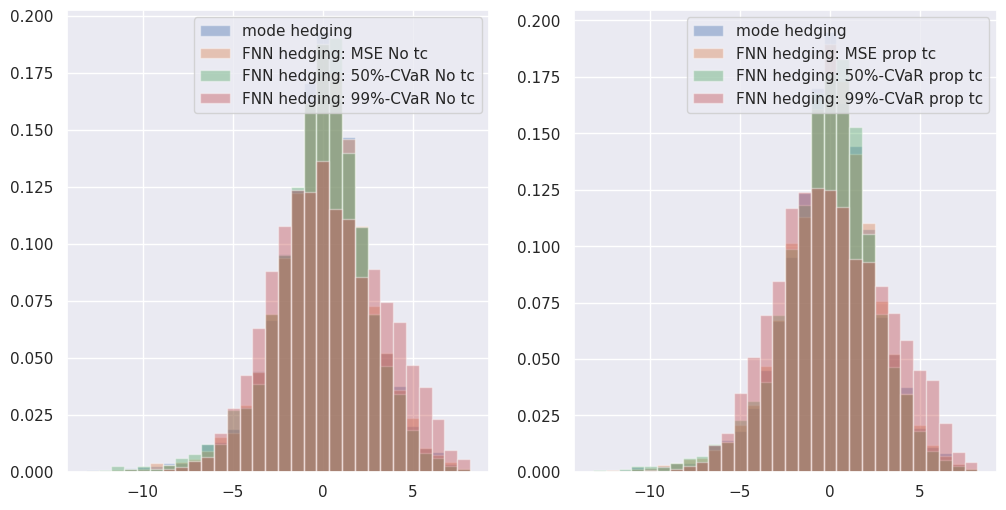

In [ ]:
# pour aligner les histogrammes on récupère les bins
_, bins = np.histogram(pnl_bs_Notc_test, bins=30)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
ax1.hist(pnl_bs_Notc_test, bins=bins, density=True, alpha=0.4, label="mode hedging")
ax1.hist(pnl_FNN_MSE_Notc_test, bins=bins, density=True, alpha=0.4, label="FNN hedging: MSE No tc")
ax1.hist(pnl_FNN_CVaR_50_Notc_test, bins=bins, density=True, alpha=0.4, label="FNN hedging: 50%-CVaR No tc")
ax1.hist(pnl_FNN_CVaR_99_Notc_test, bins=bins, density=True, alpha=0.4, label="FNN hedging: 99%-CVaR No tc")
ax1.legend()

ax2.hist(pnl_bs_tc_test, bins=bins, density=True, alpha=0.4, label="mode hedging")
ax2.hist(pnl_FNN_MSE_tc_test, bins=bins, density=True, alpha=0.4, label="FNN hedging: MSE prop tc")
ax2.hist(pnl_FNN_CVaR_50_tc_test, bins=bins, density=True, alpha=0.4, label="FNN hedging: 50%-CVaR prop tc")
ax2.hist(pnl_FNN_CVaR_99_tc_test, bins=bins, density=True, alpha=0.4, label="FNN hedging: 99%-CVaR prop tc")
ax2.legend()
plt.show()

### SRNN

In [34]:
class hedge_SRNN(nn.Module):
    def __init__(self, N, input_size, layer_sizes, output_size):
        super().__init__()
        self.price_p0 = nn.Parameter(torch.ones(1))
        self.hedge_q0 = nn.Parameter(torch.ones(1))
        self.hedge_q = nn.ModuleList([
            NeuralNetwork(input_size+1, layer_sizes, output_size) for n in range(1,N) 
        ])
    def forward(self, n, x):
        if n == 0: 
            return self.price_p0, self.hedge_q0
        else:
          batch_size=x.shape[0]
          prev_hedge=torch.full((batch_size,1), self.hedge_q0.item())
          for i in range(1,n):
            inputs=torch.cat((x[:,[i]],prev_hedge),dim=-1)
            prev_hedge=self.hedge_q[i-1](inputs)
          inputs_f=torch.cat((x[:,[n]],prev_hedge),dim=-1)
          return self.hedge_q[n-1](inputs_f)

#### Model training 

In [35]:
##### To save time, you can load the saved models and ignore the next cell: all these models are in the "BS/SRNN/prop transaction costs"
# with prop trans cost models
root_bs_SRNN_tc = "Models/BS/SRNN/Prop trans costs/"
phi_SRNN_MSE_tc=hedge_SRNN(N, 1, [16, 16, 16],1)
phi_SRNN_MSE_tc.load_state_dict(torch.load(root_bs_SRNN_tc+"BS_SRNN_MSE_tc.pth")) 
phi_SRNN_CVaR_50_tc=hedge_SRNN(N, 1, [16, 16, 16],1)
phi_SRNN_CVaR_50_tc.load_state_dict(torch.load(root_bs_SRNN_tc+"BS_SRNN_CVaR_50_tc.pth"))
phi_SRNN_CVaR_99_tc=hedge_SRNN(N, 1, [16, 16, 16],1)
phi_SRNN_CVaR_99_tc.load_state_dict(torch.load(root_bs_SRNN_tc+"BS_SRNN_CVaR_99_tc.pth"))

<All keys matched successfully>

In [36]:
# with prop transaction costs: Models training
is_reccurent = True
with_tc= True
prop = True
c=0.01

In [ ]:
## MSE
phi_SRNN_MSE_tc=hedge_SRNN(N, 1, [16, 16, 16],1)
losses_SRNN_MSE_tc= learning_from_data(xj_path, zj, phi_SRNN_MSE_tc, n_epochs, batch_size,is_reccurent=is_reccurent,with_tc=with_tc,prop=prop,c=c)
## CVaR 50% 
phi_SRNN_CVaR_50_tc=hedge_SRNN(N, 1, [16, 16, 16],1)
#p=0.5
losses_SRNN_CVaR_50_tc= learning_from_data(xj_path, zj, phi_SRNN_CVaR_50_tc, n_epochs, batch_size,is_reccurent=is_reccurent,criterion='CVaR',p=0.5,with_tc=with_tc,prop=prop,c=c)
## CVaR 99% 
phi_SRNN_CVaR_99_tc=hedge_SRNN(N, 1, [16, 16, 16],1)
#p=0.01
losses_SRNN_CVaR_99_tc= learning_from_data(xj_path, zj, phi_SRNN_CVaR_99_tc, n_epochs, batch_size,is_reccurent=is_reccurent,criterion='CVaR',p=0.01,with_tc=with_tc,prop=prop,c=c)

100%|██████████| 32/32 [09:09<00:00, 17.18s/it, loss=0.0419]


In [ ]:
# Save models 
torch.save(phi_SRNN_MSE_tc.state_dict(),"BS_SRNN_MSE_tc.pth")
torch.save(phi_SRNN_CVaR_50_tc.state_dict(),"BS_SRNN_CVaR_50_tc.pth")
torch.save(phi_SRNN_CVaR_99_tc.state_dict(),"BS_SRNN_CVaR_99_tc.pth")

In [37]:
pnl_SRNN_MSE_tc= L*pnl_BS(xj_path, zj, phi_SRNN_MSE_tc,is_reccurent=is_reccurent,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
pnl_SRNN_CVaR_50_tc = L*pnl_BS(xj_path, zj, phi_SRNN_CVaR_50_tc,is_reccurent=is_reccurent,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
pnl_SRNN_CVaR_99_tc= L*pnl_BS(xj_path, zj, phi_SRNN_CVaR_99_tc,is_reccurent=is_reccurent,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x0 = pnl_bs_tc
x1 = pnl_SRNN_MSE_tc
x2 = pnl_SRNN_CVaR_50_tc
x3 = pnl_SRNN_CVaR_99_tc

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='Model hedge', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[0] ,
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x1,
    histnorm='percent',
    name='SRNN hedging- MSE', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[1],
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x2,
    histnorm='percent',
    name='SRNN hedging- 50% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[2],
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x3,
    histnorm='percent',
    name='SRNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.5
    ),
    marker_color=list_of_colors[3],
    opacity=0.75
))



fig.update_layout(
    width = 1000,
    height = 500,
    title_text='Comparison of model hedge and SRNN hedge with different criterion with prop transaction costs: 0.01%', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

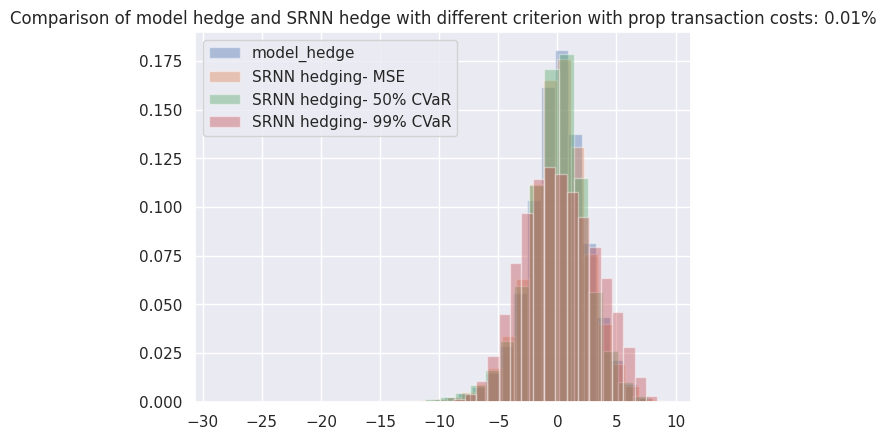

In [ ]:
bins=30
fig, ax = plt.subplots()
ax.hist(pnl_bs_tc,bins=bins, density=True, alpha=0.4, label="model_hedge")
ax.hist(pnl_SRNN_MSE_tc,bins=bins, density=True, alpha=0.4, label="SRNN hedging- MSE")
ax.hist(pnl_SRNN_CVaR_50_tc,bins=bins, density=True, alpha=0.4, label="SRNN hedging- 50% CVaR")
ax.hist(pnl_SRNN_CVaR_99_tc,bins=bins, density=True, alpha=0.4, label="SRNN hedging- 99% CVaR")
ax.legend()
plt.title("Comparison of model hedge and SRNN hedge with different criterion with prop transaction costs: 0.01%")
plt.show()

#### Model Testing

In [38]:
test_size = 2**12
xj_test, zj_test = simu_data(test_size)

with torch.no_grad():
    pnl_bs_tc_test = L*pnl_BS(xj_test, zj_test, bs_hedge,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
    pnl_SRNN_MSE_tc_test = L*pnl_BS(xj_test, zj_test, phi_SRNN_MSE_tc,is_reccurent=is_reccurent,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
    pnl_SRNN_CVaR_50_tc_test = L*pnl_BS(xj_test, zj_test, phi_SRNN_CVaR_50_tc,is_reccurent=is_reccurent,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
    pnl_SRNN_CVaR_99_tc_test = L*pnl_BS(xj_test, zj_test, phi_SRNN_CVaR_99_tc,is_reccurent=is_reccurent,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
    

In [ ]:
%%time
x0 = pnl_bs_tc_test
x1 = pnl_SRNN_MSE_tc_test
x2 = pnl_SRNN_CVaR_50_tc_test
x3 = pnl_SRNN_CVaR_99_tc_test

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='Model hedge', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.3
    ),
    marker_color=list_of_colors[0] ,
    opacity= 1.0
))

fig.add_trace(go.Histogram(
    x=x1,
    histnorm='percent',
    name='SRNN hedging- MSE', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.3
    ),
    marker_color=list_of_colors[1],
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x2,
    histnorm='percent',
    name='SRNN hedging- 50% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.3
    ),
    marker_color=list_of_colors[2],
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x3,
    histnorm='percent',
    name='SRNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.3
    ),
    marker_color=list_of_colors[3],
    opacity=0.75
))



fig.update_layout(
    width = 1000,
    height = 500,
    title_text='Comparison of model hedge and SRNN hedge with different criterion with prop transaction costs: 0.01% on test dataset', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.5, # gap between bars of adjacent location coordinates
    bargroupgap=0.2 # gap between bars of the same location coordinates
)

fig.show()

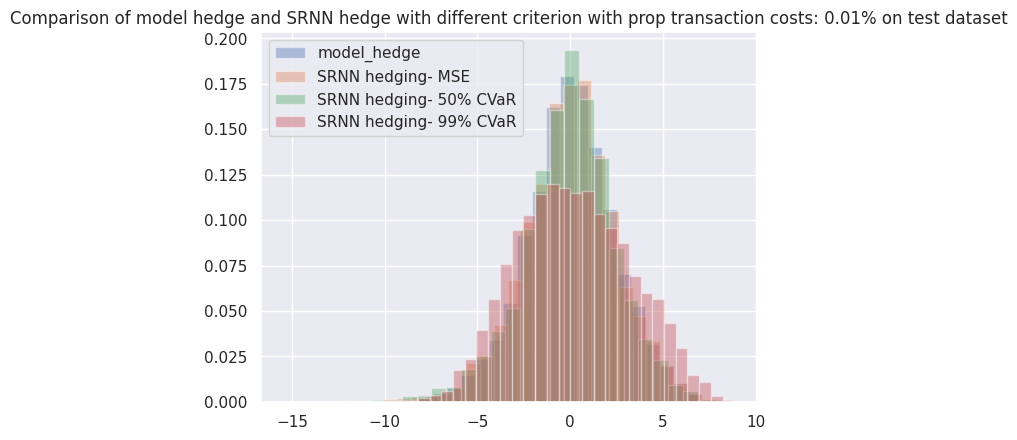

In [ ]:
bins=30
fig, ax = plt.subplots()
ax.hist(pnl_bs_tc_test,bins=bins, density=True, alpha=0.4, label="model_hedge")
ax.hist(pnl_SRNN_MSE_tc_test,bins=bins, density=True, alpha=0.4, label="SRNN hedging- MSE")
ax.hist(pnl_SRNN_CVaR_50_tc_test,bins=bins, density=True, alpha=0.4, label="SRNN hedging- 50% CVaR")
ax.hist(pnl_SRNN_CVaR_99_tc_test,bins=bins, density=True, alpha=0.4, label="SRNN hedging- 99% CVaR")
ax.legend()
plt.title("Comparison of model hedge and SRNN hedge with different criterion with prop transaction costs: 0.01% on test dataset")
plt.show()

### FFNN VS SRNN 

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x0 = pnl_bs_tc_test
x1 = pnl_SRNN_CVaR_99_tc_test
x2 = pnl_FNN_CVaR_99_tc_test

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='Model hedge', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.3
    ),
    marker_color=list_of_colors[0] ,
    opacity= 1.0
))

fig.add_trace(go.Histogram(
    x=x1,
    histnorm='percent',
    name='SRNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.3
    ),
    marker_color=list_of_colors[1],
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x2,
    histnorm='percent',
    name='FFNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.3
    ),
    marker_color=list_of_colors[2],
    opacity=0.75
))

fig.update_layout(
    width = 1000,
    height = 500,
    title_text='Comparison of FFNN hedge and SRNN hedge with 99%-CVaR criterion with prop transaction costs: 0.01% on test dataset', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.05, # gap between bars of adjacent location coordinates
    bargroupgap=0.2 # gap between bars of the same location coordinates
)

fig.show()

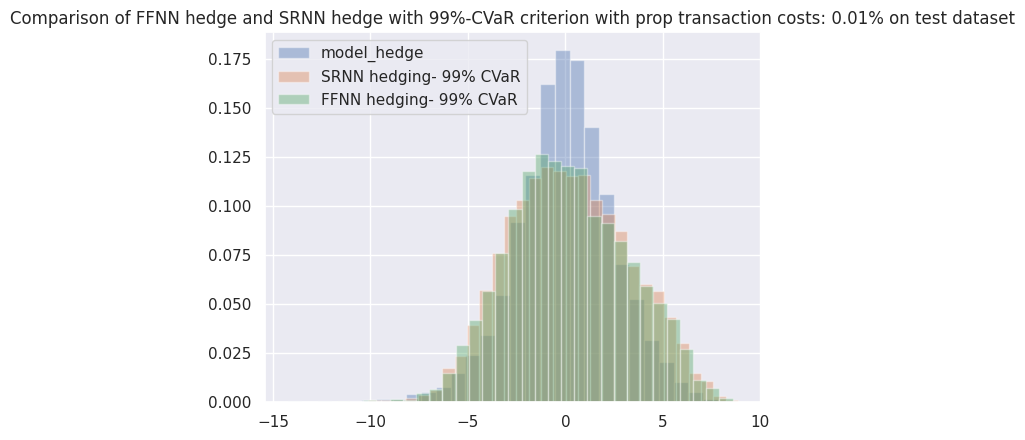

In [ ]:
bins=30
fig, ax = plt.subplots()
ax.hist(pnl_bs_tc_test,bins=bins, density=True, alpha=0.4, label="model_hedge")
ax.hist(pnl_SRNN_CVaR_99_tc_test,bins=bins, density=True, alpha=0.4, label="SRNN hedging- 99% CVaR")
ax.hist(pnl_FNN_CVaR_99_tc_test,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 99% CVaR")
ax.legend()
plt.title("Comparison of FFNN hedge and SRNN hedge with 99%-CVaR criterion with prop transaction costs: 0.01% on test dataset")
plt.show()

In [ ]:
print("=== Results for SRNN ===")
print("Mean loss:",np.array(losses_SRNN_CVaR_99_tc).mean())
print("Price:",L*phi_SRNN_CVaR_99_tc(0, xj_path[:,[0]])[0])
print("=== Results for FFNN ===")
print("Mean loss:",np.array(losses_CVaR_99_tc).mean())
print("Price:",L*phi_CVaR_99_tc(0, xj_path[:,[0]])[0])

In [41]:
print("=== Results for SRNN ===")
print("Realized 50 % CVaR:", pnl_SRNN_CVaR_50_tc.mean())
print("Realized 99 % CVaR:", pnl_SRNN_CVaR_99_tc.mean())
print("=== Results for FFNN ===")
print("Realized 50 % CVaR:", pnl_FNN_CVaR_50_tc.mean())
print("Realized 99 % CVaR:", pnl_FNN_CVaR_99_tc.mean())

=== Results for SRNN ===
Realized 50 % CVaR: -0.10025511
Realized 99 % CVaR: 0.201456
=== Results for FFNN ===
Realized 50 % CVaR: -0.09015193
Realized 99 % CVaR: 0.15420869


# 2 . Under Heston

In [42]:
# parameters for the simulation: 
S0 = 100.0
a = 1
mu = 0.0
b = 0.04
rho = -0.7
sigma = 0.2
V0 = 0.04
N = 30
r = 0.0# risk free interest rate
K = 101.0 # strike price  
kappa = a
theta  = b
T = N/365
paths = int(100)
typ = 1
I = 40
J = 20
V = 1
#dt = 1/4000
k = np.log(K/S0)
lambd=0
heston_params = {"S0":S0,
                 "a":a,
                 "mu":mu,
                 "b":b,
                 "rho":rho,
                 "sigma":sigma,
                 "V0":V0,
                 "T":T,
                 "N":N,
                 "paths":paths}

## Paths simulation: Variance, Stock price, Variance Swap

In [43]:
def Heston_pahts(S0:float, mu: float, a:float,b : float, rho : float, sigma: float, V0: float, T: float,N:int,paths: int) -> (np.array, np.array, np.array) :
    """_This function simulate paths of heston model_

    Args:
        S0 (float): _initial stocj price_
        mu (float): _drift of the stock price process_
        a (float): _Mean reversion speed of the variance process_
        b (float): _long-run variance level of the variance process_
        rho (float): _correlation between the stock price and the variance processes_
        sigma (float): _volatility of the variance process_
        V0 (float): _initial variance_
        T (float): _Time horizon_
        N (int): _Number of time steps_
        paths (int): _Number of paths to simulate_

    Returns:
       Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple containing three numpy arrays:
            - The simulated stock price paths.
            - The simulated variance paths.
            - The simulated variance swap paths.
    """
   
    
    
    # we need always the same paths 
    np.random.seed(0)
    # Here we build 2 correlated standard gaussian  for the model
    MU = np.array([0,0])
    COV = np.array([[1, rho], [rho, 1]])
    times = np.arange(N+1)*T/N    
    Z = stats.multivariate_normal.rvs(mean = MU, cov = COV, size = (paths, N))    
    B = np.zeros((paths, N+1))
    W = np.zeros((paths, N+1))
    B[:,1:] = Z[:,:,0]
    W[:,1:] = Z[:,:,1]   
    #Feller condition : This condition is important because there can be some errors while simulating the paths 
    assert(2*a*b > sigma**2)    
    # Here we use the explicit discontinuous Euler scheme on [0,T] with step T/N    
    dt = T/N 
    sq_dt = np.sqrt(dt) # for the brownian increments in the euler scheme     
    v = np.zeros(N+1) # this variable is for storing exponential of variance  process    
    Y = np.zeros((paths, N+1))
    Y[:,0] = np.log(S0)
    K = np.zeros((paths, N+1))
    K[:, 0] = np.log(V0)    
    X = np.zeros((paths, N+1)) # this is to account 
    L = np.zeros((paths, N+1))
    # Here we perform a Euler discreitzation scheme both on exp(S) ans exp(V) all the equations
    # are derived using ito formula   
    # iteration over the for loop to update the values of S and V:0    
    for t in tqdm(range(0,N)):
        v = np.exp(K[:,t]) # variance of the process
        v_sq = np.sqrt(v) # square root for calculus purpose
        Y[:, t+1] = Y[:, t] + (mu - 0.5*v) * dt + v_sq * B[:, t] * sq_dt
        K[:,t+1] = K[:, t] + ( a * ( b - v) -0.5 * sigma**2 )* dt / v + sigma * W[:, t] * sq_dt / v_sq
        L[:,t] = (v - b) * (1.0 - np.exp(-a * (T - times[t]))) / a + b * (T - times[t])     
    # computing the dynamic of S2 
    I_V = np.cumsum(np.exp(K)*times, axis=1) * times # the integral of the variance process 
    X = I_V + L 
    return (np.exp(Y), X, np.exp(K))
    
    
def Heston_paths_plot(S0:float,mu: float,a:float,b : float, rho : float, sigma: float, V0: float,T: float,N:int,paths: int):
    
    """
    Plots the simulated paths of the Heston model for the stock price, variance swap price and variance over time.

    Args:
        S0 (float): the initial stock price.
        mu (float): the expected return of the stock.
        a (float): the mean-reversion rate of the variance.
        b (float): the long-term variance of the variance.
        rho (float): the correlation between the Brownian motions driving the stock and variance processes.
        sigma (float): the volatility of the variance.
        V0 (float): the initial variance.
        T (float): the time horizon.
        N (int): the number of time steps.
        paths (int): the number of simulated paths.

    Returns:
        None
    """
    
    S1_, S2_,  V_ = Heston_pahts(S0, mu, a, b, rho, sigma, V0, T, N, paths)
    S1, S2, V = S1_.T, S2_.T, V_.T
    fig, axs = plt.subplots(figsize=(12,6), nrows = 1, ncols = 3)
    ax1, ax2, ax3 = axs.flat
    times = np.arange(N+1)*T/N
    ax1.plot(times, S1 )
    ax1.set_xlabel("times")
    ax1.set_title("stock price ")
    ax2.plot(times, S2 )
    ax2.set_xlabel("times")
    ax2.set_title(" variance swap price")
    ax3.plot(times, V)
    ax3.set_xlabel("times")
    ax3.set_title(" Variance ")
    plt.show()
    sns.set()

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 5020.91it/s]


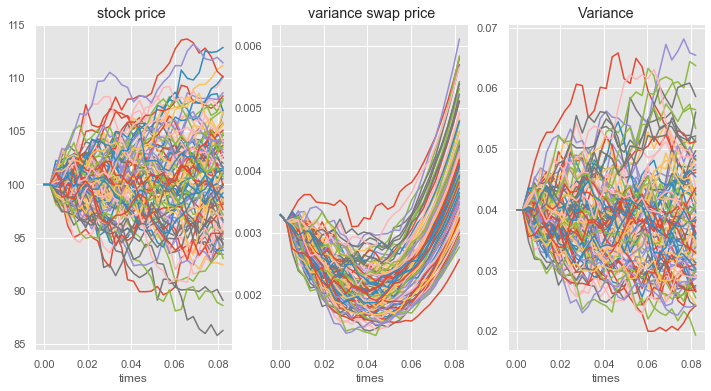

In [44]:
# Test of the simulation with input parameters of the problem 
Heston_paths_plot(**heston_params)

## Heston's Exact solution

In [45]:
def Q1(k, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the stock numeraire.
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( (np.exp(-u*k*1j) / (u*1j)) * 
                                  cf(u-1j) / cf(-1.0000000000001j) )  
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]

In [46]:
def Q2(k, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the money market numeraire
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( np.exp(-u*k*1j) /(u*1j) * cf(u) )
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]

In [47]:
def cf_Heston(u, t, v0, r, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed in the original paper of Heston (1993)
    """
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g1 = (xi+d)/(xi-d)
    cf = np.exp( 1j*u*r*t + (kappa*theta)/(sigma**2) * ( (xi+d)*t - 2*np.log( (1-g1*np.exp(d*t))/(1-g1) ))\
              + (v0/sigma**2)*(xi+d) * (1-np.exp(d*t))/(1-g1*np.exp(d*t)) )
    return cf

### Price 

In [48]:
def Heston_price(S0,K, r,T,option='Call',t=0): 
  k = np.log(K/S0)
  limit_max=1000
  cf=partial(cf_Heston, t=T-t, v0=V0, r=r, theta=theta, sigma=sigma, kappa=kappa,rho=rho)
  if (option=='Call'):
    return S0 * Q1(k, cf, limit_max) - K * np.exp(-r*(T-t)) * Q2(k, cf, limit_max)
  if (option=='Put'): 
    return S0 * Q1(k, cf, limit_max) - K * np.exp(-r*(T-t)) * Q2(k, cf, limit_max) +K*np.exp(-r*(T-t))-S0

In [49]:
%%time
P0e=Heston_price(S0,K, r,T)
print("Heston call price:",Heston_price(S0,K, r,T))
print("Heston put price:",Heston_price(S0,K, r,T,'Put'))
print("-----------------")

Heston call price: 1.8040859854756661
Heston put price: 2.804085985475666
-----------------
Wall time: 101 ms


### Delta 

In [50]:
def delta_heston (S0,K, r,T,option='Call',t=0): 
  k = np.log(K/S0)
  limit_max=1000
  cf=partial(cf_Heston, t=T-t, v0=V0, r=r, theta=theta, sigma=sigma, kappa=kappa,rho=rho)
  delta_call=Q1(k, cf, limit_max)
  if (option=='Call'):
    return delta_call
  if (option=='Put'):
    return delta_call-1

In [51]:
%%time
print('delta call:',delta_heston (S0,K, r,T))
print('delta_put',delta_heston (S0,K, r,T,option='Put'))
print("-------------")

delta call: 0.4608565972852376
delta_put -0.5391434027147624
-------------
Wall time: 14.5 ms


### Vega

In [52]:
def D_calculation(u, t, v0, r, kappa, theta, sigma, rho): 
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u))
    g1 = (xi+d)/(xi-d)    
    D=(v0/sigma**2)*(xi+d) * (1-np.exp(d*t))/(1-g1*np.exp(d*t)) 
    return D

In [53]:
def vega(k,D, right_lim,t=0):
    cf=partial(cf_Heston, t=T-t, v0=V0, r=r, theta=theta, sigma=sigma, kappa=kappa,rho=rho)
    integrand = lambda u: np.real( np.exp(-u*k*1j) /(u*1j) * cf(u) * D(u) )
    return 1/np.pi * quad(integrand, 1e-15, right_lim, limit=5000 )[0]  

In [54]:
%%time
right_lim=5000
D=partial(D_calculation, t=T, v0=V0, r=r, theta=theta, sigma=sigma, kappa=kappa,rho=rho)
print("Vega:",vega(k,D,right_lim))
print("------------------")

Vega: 0.01938883501459914
------------------
Wall time: 13 ms


## Data preprocessing

In [55]:
S1, S2, V = Heston_pahts(**heston_params)
times = np.arange(N+1)*T/N

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 15015.41it/s]


In [56]:
S1 = S1.T
S2=S2.T
V = V.T
S1_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * S1
S2_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * S2
V_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * V

In [57]:
L = 2*S0
data_size = paths
S1j_path = torch.from_numpy(S1_act).to(device).float().T / L
S2j_path = torch.from_numpy(S2_act).to(device).float().T / L
zj = torch.from_numpy(np.exp(-r*T)*np.maximum(S1[N]-K, 0))[:,None].to(device).float() / L

In [58]:
print("plage de valeur des s1j_path: ", S1j_path.min(), S1j_path.max())
print("plage de valeur des S2j_path: ", S2j_path.min(), S2j_path.max())
print("plage de valeur des zj:      ", zj.min(), zj.max())

plage de valeur des s1j_path:  tensor(0.4288) tensor(0.5686)
plage de valeur des S2j_path:  tensor(6.7097e-06) tensor(3.0590e-05)
plage de valeur des zj:       tensor(0.) tensor(0.0596)


## PnL Modelling

In [59]:
 def pnl_heston(S1j_path, S2j_path, zj, phi): 
    value = np.zeros_like(S1j_path[:,[0]])
    deltas = []
    deltav = []
    p0, delta10, delta20 = phi(0, S1j_path[:,[0]], S2j_path[:,[0]])
    deltas.append(delta10)
    deltav.append(delta20)
    value = p0 - delta10 * S1j_path[:,[0]] - delta20 * S2j_path[:,[0]]
    for n in range(1,N):
        delta1n , delta2n = phi(n, S1j_path[:,[n]] , S2j_path[:,[n]])
        deltas.append(delta1n)
        deltav.append(delta2n)
        value = value - (deltas[n] - deltas[n-1]) * S1j_path[:,[n]] -(deltav[n] - deltav[n-1]) * S2j_path[:,[n]]
    value = value + deltas[N-1] * S2j_path[:,[N]] + deltav[N-1] * S2j_path[:,[N]] - zj
    return value * np.exp(r*T)

## Model Hedge 

In [60]:
def delta_hedging_different_pahts(S,V,t,K,T,r,kappa,theta,sigma,rho) -> (np.array, np.array):
    limit_max = 1000
    res_s = []
    res_v = []
    for i in tqdm(range(len(S))):
        cf  = partial(cf_Heston,T- t, V[i], r, theta, sigma,  kappa, rho) 
        k = np.log(K/S[i]) # log moneyness
        res_s.append(Q1(k, cf, limit_max))
        d = partial(D_calculation, t=T-t, v0=V[i], r=r, theta=theta, sigma=sigma, kappa=kappa,rho=rho)
        res_v.append((vega(k,cf,d, limit_max)))         
    return np.array(res_s), np.array(res_v)

In [61]:
def hs_hedge(n, sn,vn):
    if n == 0: 
      res = delta_hedging_different_pahts(L*sn.detach().numpy(),L*vn.detach().numpy(),0,K,T,r,kappa,theta,sigma,rho)
      delta_s_0=res[0]
      delta_v_0=res[1]
      return (P0e/L,torch.from_numpy(delta_s_0).to(device).float(),torch.from_numpy(delta_v_0).to(device).float())
    res = delta_hedging_different_pahts(L*np.exp(r*n*T/N)*sn.detach().numpy(),L*np.exp(r*n*T/N)*vn.detach().numpy(),T*n/N,K,T,r,kappa,theta,sigma,rho)
    delta_s_n=res[0]
    delta_v_n=res[1]
    return (torch.from_numpy(delta_s_n).to(device).float(),torch.from_numpy(delta_v_n).to(device).float())  

In [127]:
### To save time you can load the saved PnL and ignore the next cell (it takes 40 min for 100 simulations): you can find the pnl in Heston/Model_hedge
root_hs_pickle = "Models/Heston/Model_hedge/"
pnl_hs = pd.read_pickle(root_hs_pickle+"pnl_hs.pickle")
pnl_hs = pnl_hs.to_numpy()

In [ ]:
pnl_hs = L * pnl_heston(S1j_path, S2j_path, zj, hs_hedge).detach().numpy().flatten()

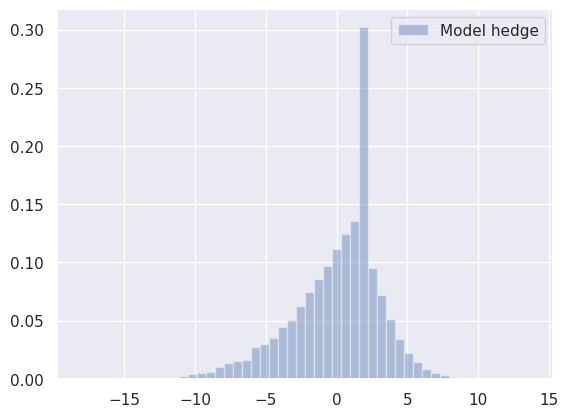

In [129]:
fig, ax = plt.subplots()
ax.hist(pnl_hs,bins=50, density=True, alpha=0.4, label="Model hedge")
ax.legend()
sns.set()
plt.show()

## Neural Network Hedge 

In [62]:
n_epochs = 32
batch_size = 2**12

In [63]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size):
        super().__init__()
        layers = [ nn.Linear(input_size, layer_sizes[0]),
                   nn.ReLU() ]
        for (ls_in, ls_out) in zip(layer_sizes, layer_sizes[1:]):
            layers.append(nn.Linear(ls_in, ls_out))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-1], output_size))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [64]:
# Data for training the neural network
heston_params["paths"] = int(2**20)
S1, S2, V = Heston_pahts(**heston_params)
S1 = S1.T
S2=S2.T
V = V.T
S1_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * S1
S2_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * S2
V_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * V

# on normalise (pour faciliter la descente de gradient) de façon en divisant tout par L = 200 (2*x0) 
L = 2*S0
data_size = paths
S1j_path = torch.from_numpy(S1_act).to(device).float().T / L
S2j_path = torch.from_numpy(S2_act).to(device).float().T / L
zj = torch.from_numpy(np.exp(-r*T)*np.maximum(S1[N]-K, 0))[:,None].to(device).float() / L

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.36it/s]


In [65]:
def pnl_Heston_NN(S1j_path, S2j_path, zj, phi,is_reccurent=False,with_tc=False,prop=True,c=0): 
    """_This function calculates the P&L of a trading strategy based on the Heston model 
    and a neural network estimator for the option deltas_

    Args:
      S1j_path (_array_): _2D array of shape (paths,N+1) containing the simulated paths of the stock price process_
      S2j_path (_array_): _ a 2D numpy array of shape (paths, N+1) containing the simulated paths of the variance swap price process_
      zj (_array_): _1D numpy array of shape (paths,) containing the payoff_
      phi (_function_): _a function that takes as input the time step n and the current state x_j (a 2D numpy array of shape (paths, 2) containing the current stock and variance swap prices) and returns the option deltas at time n, as well as the NN output p0 at time 0_
      is_reccurent (bool, optional): _a boolean indicating whether the phi function is recurrent (i.e., takes as input the entire path x_j) or feedforward (i.e., takes as input only the current state x_j[:,[n]])_. Defaults to False.
      with_tc (bool, optional): _a boolean indicating whether to include transaction costs in the P&L calculation_. Defaults to False.
      prop (bool, optional): _a boolean indicating whether the transaction costs are proportional or fixed_. Defaults to True.
      c (float, optional): _a float indicating the transaction cost rate (in percentage)_. Defaults to 0.

    Returns:
      _array_: _1D numpy array of shape (paths,) containing the P&L of the trading strategy for each simulation path. The P&L is multiplied by the exponential of the risk-free interest rate r times the time horizon T._
    """
    value = np.zeros_like(S1j_path[:,[0]])
    deltas = []
    deltav = []
    x_0=torch.cat((S1j_path[:,[0]] , S2j_path[:,[0]]),dim=-1)
    p0, delta10, delta20 = phi(0, x_0)
    deltas.append(delta10)
    deltav.append(delta20)
    value = p0 - delta10 * S1j_path[:,[0]] - delta20 * S2j_path[:,[0]]
    for n in range(1,N):
        if is_reccurent == True :
          x_j=torch.cat((S1j_path , S2j_path),dim=-1)
        else:        
          x_j=torch.cat((S1j_path[:,[n]] , S2j_path[:,[n]]),dim=-1)
        delta1n , delta2n = phi(n, x_j)
        deltas.append(delta1n)
        deltav.append(delta2n)
        if with_tc==True:
          if prop== True: 
            value = value - (deltas[n] - deltas[n-1]) * S1j_path[:,[n]] -(deltav[n] - deltav[n-1]) * S2j_path[:,[n]]-(abs(deltas[n]-deltas[n-1])*(c/100)*S1j_path[:,[n]])-(abs(deltav[n]-deltav[n-1])*(c/100)*S2j_path[:,[n]])
          else: 
            value = value - (deltas[n] - deltas[n-1]) * S1j_path[:,[n]] -(deltav[n] - deltav[n-1]) * S2j_path[:,[n]]-(abs(deltas[n]-deltas[n-1])*(c/100))-(abs(deltav[n]-deltav[n-1])*(c/100))
        else:
          value = value - (deltas[n] - deltas[n-1]) * S1j_path[:,[n]] -(deltav[n] - deltav[n-1]) * S2j_path[:,[n]]
    value = value + deltas[N-1] * S1j_path[:,[N]] + deltav[N-1] * S2j_path[:,[N]] - zj
    return value * np.exp(r*T)

#### FFNN 

In [66]:
class hedgeFNN_Heston(nn.Module):
    def __init__(self, N , input_size, layer_sizes, output_size):
        super().__init__()
        self.price_p0 = nn.Parameter(torch.ones(1))
        self.hedge_qs0 = nn.Parameter(torch.ones(1))
        self.hedge_qv0 = nn.Parameter(torch.ones(1))
        self.hedge_qs = nn.ModuleList([NeuralNetwork(input_size, layer_sizes, output_size) for n in range(1,N)])
        self.hedge_qv = nn.ModuleList([NeuralNetwork(input_size, layer_sizes, output_size) for n in range(1,N)])
        
    def forward(self, n, x):
        if n == 0:
            return self.price_p0, self.hedge_qs0, self.hedge_qv0
        else:
            return self.hedge_qs[n-1](x),self.hedge_qv[n-1](x)

##### Model training

In [67]:
def learning_from_data_Heston(S1j_path,S2j_path, zj, phi, n_epochs, batch_size,criterion='MSE',p=0.5, is_reccurent=False,with_tc=False,prop=True,c=0,learning_rate=1e-3): 
    """_Train a neural network to learn the optimal hedging strategy using the Heston model._

    Args:
      S1j_path (_array_): _2D array of shape (paths,N+1) containing the simulated paths of the stock price process_
      S2j_path (_array_): _ a 2D numpy array of shape (paths, N+1) containing the simulated paths of the variance swap price process_
      zj (_array_): _1D numpy array of shape (paths,) containing the payoff_
      phi (_function_): _a function that takes as input the time step n and the current state x_j (a 2D numpy array of shape (paths, 2) containing the current stock and variance swap prices) and returns the option deltas at time n, as well as the NN output p0 at time 0_
      is_reccurent (bool, optional): _a boolean indicating whether the phi function is recurrent (i.e., takes as input the entire path x_j) or feedforward (i.e., takes as input only the current state x_j[:,[n]])_. Defaults to False.
      with_tc (bool, optional): _a boolean indicating whether to include transaction costs in the P&L calculation_. Defaults to False.
      prop (bool, optional): _a boolean indicating whether the transaction costs are proportional or fixed_. Defaults to True.
      c (float, optional): _a float indicating the transaction cost rate (in percentage)_. Defaults to 0.
      n_epochs (_int_): _number of training epochs_
      batch_size (_int_): _the size of each mini-batch for training_
      criterion (str, optional): _the loss function to be used, either 'MSE' for mean squared error or 'CVaR' for Conditional Value at Risk_. Defaults to 'MSE'.
      p (float, optional): _the confidence level for CVaR loss_. Defaults to 0.5.
      learning_rate (_type_, optional): _description_. Defaults to 1e-3.

    Returns:
      _type_: _description_
    """
    data_size = zj.shape[0]
    n_upd = data_size // batch_size 
    optimizer = torch.optim.Adam(phi.parameters(), lr=learning_rate)
    losses = []
    with tqdm(range(n_epochs)) as nrange:
        for n in nrange:
            indexes = torch.randperm(data_size)   
            for k in range(n_upd):
                idx = indexes[k*batch_size:(k+1)*batch_size] 
                if criterion == 'MSE':
                  loss = (pnl_Heston_NN(S1j_path[[idx]], S2j_path[[idx]], zj[[idx]], phi,is_reccurent,with_tc,prop,c)**2).mean() 
                if criterion =='CVaR':
                  pl = pnl_Heston_NN(S1j_path[[idx]], S2j_path[[idx]], zj[[idx]], phi,is_reccurent,with_tc,prop,c) 
                  neg_pl=torch.abs(-pl)
                  top_neg_pl=neg_pl.topk(ceil(p * neg_pl.size(dim=0)), dim=0, largest=True).values
                  loss=top_neg_pl.mean(dim=0)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()  
                losses.append(loss.item())
            nrange.set_postfix(loss=loss.item())
    return losses

In [68]:
### To save time, you can load the saved model and ignore the next cell, you can find the models is : Heston/FFNN/No transaction costs
# No transaction costs models
root_hs_no_costs = "Models/Heston/FFNN/No transaction costs/"
phi_hs_MSE_Notc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
phi_hs_MSE_Notc.load_state_dict(torch.load(root_hs_no_costs+"hs_FFNN_MSE_Notc.pth")) 
phi_hs_CVaR_50_Notc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
phi_hs_CVaR_50_Notc.load_state_dict(torch.load(root_hs_no_costs+"hs_FFNN_CVaR_50_Notc.pth"))
phi_hs_CVaR_99_Notc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
phi_hs_CVaR_99_Notc.load_state_dict(torch.load(root_hs_no_costs+"hs_FFNN_CVaR_99_Notc.pth"))

<All keys matched successfully>

In [ ]:
# No Transaction costs: Models training 
## MSE
phi_hs_MSE_Notc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
losses_hs_MSE_Notc= learning_from_data_Heston(S1j_path,S2j_path, zj, phi_hs_MSE_Notc, n_epochs, batch_size)
## CVaR 50% 
phi_hs_CVaR_50_Notc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
#p=0.5
losses_hs_CVaR_50_Notc= learning_from_data_Heston(S1j_path,S2j_path, zj, phi_hs_CVaR_50_Notc, n_epochs, batch_size,criterion='CVaR',p=0.5)
## CVaR 99% 
phi_hs_CVaR_99_Notc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
#p=0.01
losses_CVaR_99_Notc=learning_from_data_Heston(S1j_path,S2j_path, zj, phi_hs_CVaR_99_Notc, n_epochs, batch_size,criterion='CVaR',p=0.01)

In [ ]:
# Save models 
#torch.save(phi_hs_MSE_Notc.state_dict(),"hs_FFNN_MSE_Notc.pth")
#torch.save(phi_hs_CVaR_50_Notc.state_dict(),"hs_FFNN_CVaR_50_Notc.pth")
#torch.save(phi_hs_CVaR_99_Notc.state_dict(),"hs_FFNN_CVaR_99_Notc.pth")

In [69]:
with torch.no_grad():
  pnl_hs_FNN_MSE_Notc= L*pnl_Heston_NN(S1j_path, S2j_path, zj, phi_hs_MSE_Notc).detach().numpy().flatten()
  pnl_hs_FNN_CVaR_50_Notc = L*pnl_Heston_NN(S1j_path, S2j_path, zj, phi_hs_CVaR_50_Notc).detach().numpy().flatten()
  pnl_hs_FNN_CVaR_99_Notc= L*pnl_Heston_NN(S1j_path, S2j_path, zj, phi_hs_CVaR_99_Notc).detach().numpy().flatten()

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x0 = pnl_bs_tc_test
x1 = pnl_SRNN_CVaR_99_tc_test
x2 = pnl_FNN_CVaR_99_tc_test

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='FFNN hedging- MSE', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.3
    ),
    marker_color=list_of_colors[2] ,
    opacity= 0.75
))

fig.add_trace(go.Histogram(
    x=x1,
    histnorm='percent',
    name='FFNN hedging- 50% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.3
    ),
    marker_color=list_of_colors[4],
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=x2,
    histnorm='percent',
    name='FFNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-20.0,
        end=20.0,
        size=0.3
    ),
    marker_color=list_of_colors[3],
    opacity=0.75
))

fig.update_layout(
    width = 1200,
    height = 600,
    title_text='FFNN hedge with different criterion without transaction costs', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.5  # gap between bars of the same location coordinates
)

fig.show()

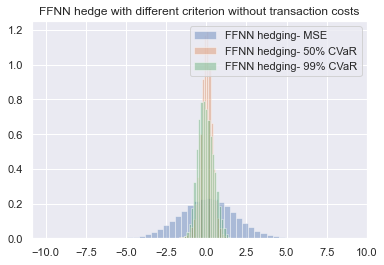

In [135]:
bins=50
fig, ax = plt.subplots()
ax.hist(pnl_hs_FNN_MSE_Notc,bins=bins, density=True, alpha=0.4, label="FFNN hedging- MSE")
ax.hist(pnl_hs_FNN_CVaR_50_Notc,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 50% CVaR")
ax.hist(pnl_hs_FNN_CVaR_99_Notc,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 99% CVaR")
ax.legend()
plt.title("FFNN hedge with different criterion without transaction costs")
plt.show()

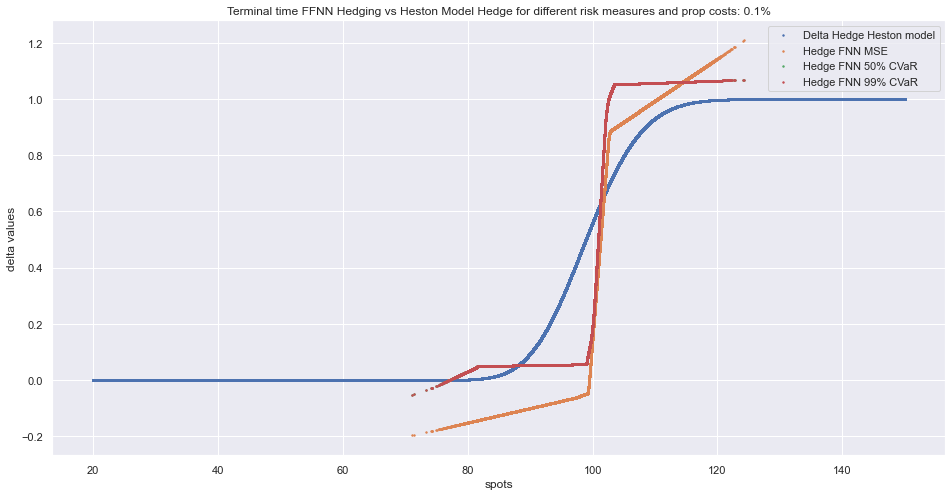

Wall time: 1min 14s


In [365]:
%%time 

xx = np.linspace(60,140,M)
fig, ax = plt.subplots(figsize =(16,8))
zz = dprice_call_BS(xx, T)
ax.scatter(xx, zz, s=2, label="Delta Hedge Heston model", color='C0')

with torch.no_grad():
    xx1 = S1j_path[:,[N-1]]
    xx2 = S2j_path[:,[N-1]]
    # 
    xxj_path= torch.cat((xx1, xx2), dim = -1)
    xx = L * S1j_path[:,[N-1]]
    x0,_ = phi_hs_MSE_Notc(N-1, xxj_path)
    x1,_ = phi_hs_CVaR_50_Notc(N-1, xxj_path)
    x2,_ = phi_hs_CVaR_99_Notc(N-1, xxj_path)
    

ax.scatter(xx, x0, s=2, label="Hedge FNN MSE", color='C1')
ax.scatter(xx, x1, s=2, label="Hedge FNN 50% CVaR", color='C2')
ax.scatter(xx, x1, s=2, label="Hedge FNN 99% CVaR", color='C3')

plt.title("Terminal time FFNN Hedging vs Heston Model Hedge for different risk measures and prop costs: 0.1%")
ax.set_xlabel("spots")
ax.set_ylabel("delta values")
ax.legend(loc='best')
sns.set()
plt.show()

In [70]:
### To save time, you can load the saved model and ignore the next cell, you can find the models is : Heston/FFNN/No transaction costs
# Prop costs models
root_hs_FFNN_costs = "Models/Heston/FFNN/Prop transaction costs/"
phi_hs_CVaR_50_tc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
phi_hs_CVaR_50_tc.load_state_dict(torch.load(root_hs_FFNN_costs+"hs_FFNN_CVaR_50_tc.pth"))
phi_hs_CVaR_99_tc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
phi_hs_CVaR_99_tc.load_state_dict(torch.load(root_hs_FFNN_costs+"hs_FFNN_CVaR_99_tc.pth"))

<All keys matched successfully>

In [71]:
# Prop Transaction costs: Models training 
with_tc=True
prop=True
c=0.01

In [ ]:
## MSE
phi_hs_MSE_tc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
losses_hs_MSE_tc= learning_from_data_Heston(S1j_path,S2j_path, zj, phi_hs_MSE_tc, n_epochs, batch_size,with_tc=with_tc,prop=prop,c=c)
## CVaR 50% 
phi_hs_CVaR_50_tc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
#p=0.5
losses_hs_CVaR_50_tc= learning_from_data_Heston(S1j_path,S2j_path, zj, phi_hs_CVaR_50_tc, n_epochs, batch_size,criterion='CVaR',p=0.5,with_tc=with_tc,prop=prop,c=c)
## CVaR 99% 
phi_hs_CVaR_99_tc=hedgeFNN_Heston(N, 2, [16, 16, 16],1)
#p=0.01
losses_CVaR_99_tc=learning_from_data_Heston(S1j_path,S2j_path, zj, phi_hs_CVaR_99_tc, n_epochs, batch_size,criterion='CVaR',p=0.01,with_tc=with_tc,prop=prop,c=c)

In [ ]:
# Save models 
#torch.save(phi_hs_MSE_tc.state_dict(),"hs_FFNN_MSE_tc.pth")
#torch.save(phi_hs_CVaR_50_tc.state_dict(),"hs_FFNN_CVaR_50_tc.pth")
#torch.save(phi_hs_CVaR_99_tc.state_dict(),"hs_FFNN_CVaR_99_tc.pth")

In [72]:
with torch.no_grad():
  #pnl_hs_FNN_MSE_tc= L*pnl_Heston_NN(S1j_path, S2j_path, zj, phi_hs_MSE_tc).detach().numpy().flatten()
  pnl_hs_FNN_CVaR_50_tc = L*pnl_Heston_NN(S1j_path, S2j_path, zj, phi_hs_CVaR_50_tc,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
  pnl_hs_FNN_CVaR_99_tc= L*pnl_Heston_NN(S1j_path, S2j_path, zj, phi_hs_CVaR_99_tc,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x0 = pnl_hs_FNN_CVaR_50_tc
x1 = pnl_hs_FNN_CVaR_99_tc

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='FFNN hedging- 50% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-5.0,
        end=5.0,
        size=0.1
    ),
    marker_color=list_of_colors[0] ,
    opacity= 0.75
))

fig.add_trace(go.Histogram(
    x=x1,
    histnorm='percent',
    name='FFNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-5.0,
        end=5.0,
        size=0.1
    ),
    marker_color=list_of_colors[1],
    opacity=0.75
))



fig.update_layout(
    width = 1000,
    height = 500,
    title_text='FFNN hedge with different criterion with transaction costs', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.05, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

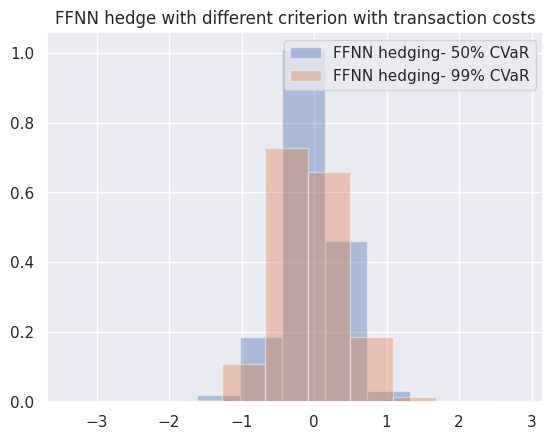

In [45]:
bins=50
fig, ax = plt.subplots()
#ax.hist(pnl_hs_FNN_MSE_tc,bins=bins, density=True, alpha=0.4, label="FFNN hedging- MSE")
ax.hist(pnl_hs_FNN_CVaR_50_tc, density=True, alpha=0.4, label="FFNN hedging- 50% CVaR")
ax.hist(pnl_hs_FNN_CVaR_99_tc, density=True, alpha=0.4, label="FFNN hedging- 99% CVaR")
ax.legend()
plt.title("FFNN hedge with different criterion with transaction costs")
plt.show()

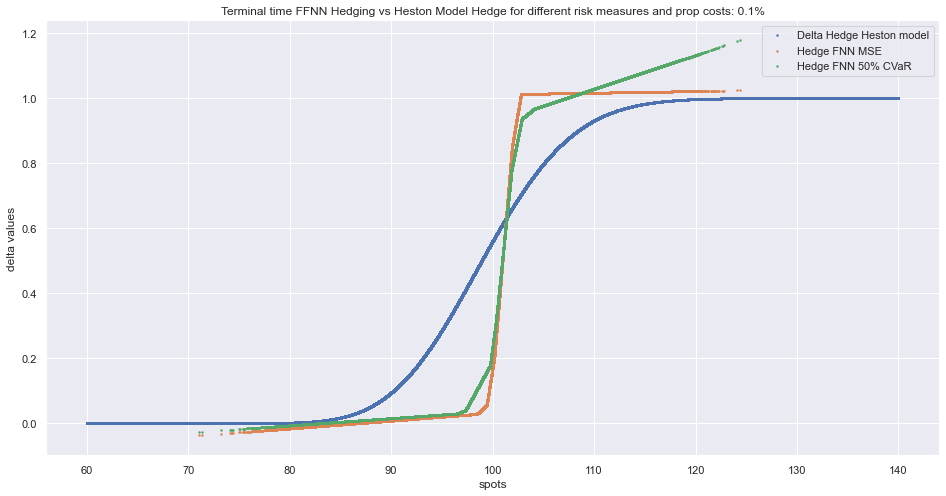

Wall time: 51.8 s


In [367]:
%%time 

xx = np.linspace(60,140,M)
fig, ax = plt.subplots(figsize =(16,8))
zz = dprice_call_BS(xx, T)
ax.scatter(xx, zz, s=2, label="Delta Hedge Heston model", color='C0')

with torch.no_grad():
    xx1 = S1j_path[:,[N-1]]
    xx2 = S2j_path[:,[N-1]]
    # 
    xxj_path= torch.cat((xx1, xx2), dim = -1)
    xx = L * S1j_path[:,[N-1]]
    x0,_ = phi_hs_CVaR_50_tc(N-1, xxj_path)
    x1,_ = phi_hs_CVaR_99_tc(N-1, xxj_path)
    

ax.scatter(xx, x0, s=2, label="Hedge FNN MSE", color='C1')
ax.scatter(xx, x1, s=2, label="Hedge FNN 50% CVaR", color='C2')

plt.title("Terminal time FFNN Hedging vs Heston Model Hedge for different risk measures and prop costs: 0.1%")
ax.set_xlabel("spots")
ax.set_ylabel("delta values")
ax.legend(loc='best')
sns.set()
plt.show()

##### Model testing

In [73]:
# Data for training the neural network
heston_params["paths"] = int(2**12)
S1_test, S2_test, _ = Heston_pahts(**heston_params)
S1_test = S1_test.T
S2_test=S2_test.T
S1_test_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * S1_test
S2_test_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * S2_test

# on normalise (pour faciliter la descente de gradient) de façon en divisant tout par L = 200 (2*x0) 
L = 2*S0
data_size = paths
S1j_test_path = torch.from_numpy(S1_test_act).to(device).float().T / L
S2j_test_path = torch.from_numpy(S2_test_act).to(device).float().T / L
zj_test = torch.from_numpy(np.exp(-r*T)*np.maximum(S1_test[N]-K, 0))[:,None].to(device).float() / L

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 4287.78it/s]


In [74]:
with torch.no_grad():
  pnl_hs_FNN_MSE_Notc_test= L*pnl_Heston_NN(S1j_test_path, S2j_test_path, zj_test, phi_hs_MSE_Notc).detach().numpy().flatten()
  pnl_hs_FNN_CVaR_50_Notc_test = L*pnl_Heston_NN(S1j_test_path, S2j_test_path, zj_test, phi_hs_CVaR_50_Notc).detach().numpy().flatten()
  pnl_hs_FNN_CVaR_99_Notc_test= L*pnl_Heston_NN(S1j_test_path, S2j_test_path, zj_test, phi_hs_CVaR_99_Notc).detach().numpy().flatten()
  pnl_hs_FNN_CVaR_50_tc_test = L*pnl_Heston_NN(S1j_test_path, S2j_test_path, zj_test, phi_hs_CVaR_50_tc,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()
  pnl_hs_FNN_CVaR_99_tc_test= L*pnl_Heston_NN(S1j_test_path, S2j_test_path, zj_test, phi_hs_CVaR_99_tc,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x10 = pnl_hs_FNN_CVaR_50_Notc_test
x11 = pnl_hs_FNN_CVaR_99_Notc_test


x20 = pnl_hs_FNN_CVaR_50_tc_test
x21 = pnl_hs_FNN_CVaR_99_tc_test


fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Histogram(
    x=x10,
    histnorm='percent',
    name='FFNN hedging- 50% CVaR without tc', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-3.0,
        end=3.0,
        size=0.1
    ),
    marker_color=list_of_colors[0] ,
    opacity=0.75),
    row = 1,
    col = 1
    )

fig.add_trace(go.Histogram(
    x=x11,
    histnorm='percent',
    name='FFNN hedging- 99% CVaR without tc', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-3.0,
        end=3.0,
        size=0.1
    ),
    marker_color=list_of_colors[1],
    opacity=0.75),
    row = 1,
    col = 1)

fig.add_trace(go.Histogram(
    x=x20,
    histnorm='percent',
    name='FFNN hedging- 50% CVaR with prop tc', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-3.0,
        end=3.0,
        size=0.1
    ),
    marker_color=list_of_colors[0] ,
    opacity=0.75),
    row = 1,
    col = 2
    )

fig.add_trace(go.Histogram(
    x=x21,
    histnorm='percent',
    name='FFNN hedging- 99% CVaR with prop tc', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-3.0,
        end=3.0,
        size=0.1
    ),
    marker_color=list_of_colors[1],
    opacity=0.75),
    row = 1,
    col = 2)

fig.update_layout(
    width = 1200,
    height = 500,
    title_text='FFNN Test No costs vs FNN Test with costs', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.5 # gap between bars of the same location coordinates
)

fig.show()

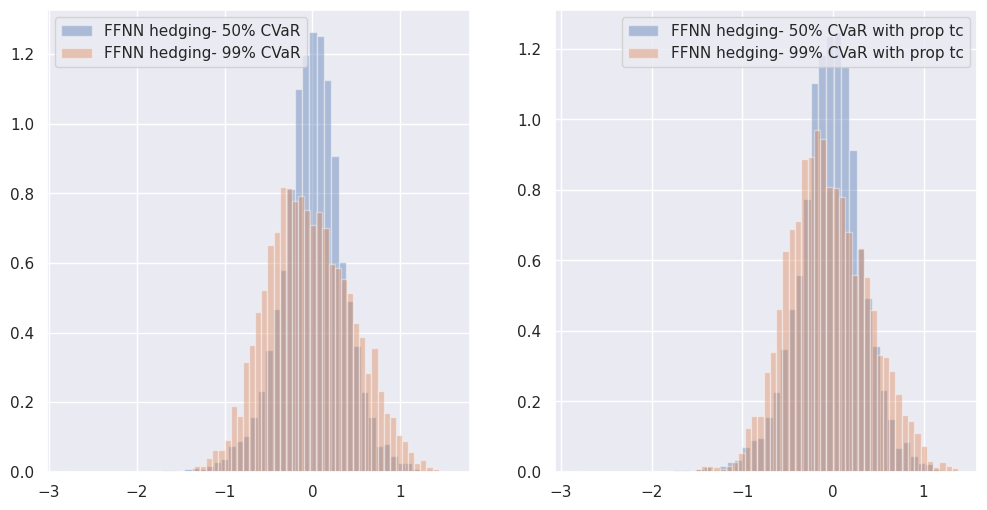

In [54]:
bins=50
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
#ax1.hist(pnl_hs_FNN_MSE_Notc_test,bins=bins, density=True, alpha=0.4, label="FFNN hedging- MSE")
ax1.hist(pnl_hs_FNN_CVaR_50_Notc_test,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 50% CVaR without tc")
ax1.hist(pnl_hs_FNN_CVaR_99_Notc_test,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 99% CVaR without tc")
ax1.legend()

ax2.hist(pnl_hs_FNN_CVaR_50_tc_test,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 50% CVaR with prop tc")
ax2.hist(pnl_hs_FNN_CVaR_99_tc_test,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 99% CVaR with prop tc")
ax2.legend()

plt.show()

#### SRNN

In [75]:
class hedgeSRNN_Heston(nn.Module):
    def __init__(self, N , input_size, layer_sizes, output_size):
        super().__init__()
        self.price_p0 = nn.Parameter(torch.ones(1))
        self.hedge_qs0 = nn.Parameter(torch.ones(1))
        self.hedge_qv0 = nn.Parameter(torch.ones(1))
        self.hedge_qs = nn.ModuleList([NeuralNetwork(input_size+2, layer_sizes, output_size) for n in range(1,N)])
        self.hedge_qv = nn.ModuleList([NeuralNetwork(input_size+2, layer_sizes, output_size) for n in range(1,N)])       
    def forward(self, n, x):
        if n == 0:
            return self.price_p0, self.hedge_qs0, self.hedge_qv0
        else:
          batch_size=x.shape[0]
          prev_hedge_s=torch.full((batch_size,1), self.hedge_qs0.item())
          prev_hedge_v=torch.full((batch_size,1), self.hedge_qv0.item())
          for i in range(1,n):
            inputs=torch.cat((x[:,[i,i+N+1]],prev_hedge_s,prev_hedge_v),dim=-1)
            prev_hedge_s=self.hedge_qs[i-1](inputs)
            prev_hedge_v=self.hedge_qv[i-1](inputs)
          inputs_f=torch.cat((x[:,[n,n+N+1]],prev_hedge_s,prev_hedge_v),dim=-1)
          return self.hedge_qs[n-1](inputs_f),self.hedge_qv[n-1](inputs_f)

##### Model Training 

In [76]:
##### To save time, you can load the saved models and ignore the next cell: all these models are in the "BS/SRNN/prop transaction costs"
# with prop trans cost models
root_hs_SRNN_costs = "Models/Heston/SRNN/"
phi_SRNN_CVaR_99_tc=hedgeSRNN_Heston(N, 2, [16, 16, 16],1)
phi_SRNN_CVaR_99_tc.load_state_dict(torch.load(root_hs_SRNN_costs+ "hs_SRNN_CVaR_99_tc.pth")) 


<All keys matched successfully>

In [77]:
# with prop transaction costs + 99%-CVaR criterion: Model training
is_reccurent = True
with_tc= True
prop = True
c=0.01

In [ ]:
## CVaR 99% 
phi_SRNN_CVaR_99_tc=hedgeSRNN_Heston(N, 2, [16, 16, 16],1)
#p=0.01
losses_SRNN_CVaR_99_tc= learning_from_data_Heston(S1j_path, S2j_path, zj, phi_SRNN_CVaR_99_tc, n_epochs, batch_size,is_reccurent=is_reccurent,criterion='CVaR',p=0.01,with_tc=with_tc,prop=prop,c=c)

In [ ]:
# Save models 
#torch.save(phi_SRNN_CVaR_99_Notc.state_dict(),"hs_SRNN_CVaR_99_Notc.pth")

In [78]:
with torch.no_grad():
  pnl_hs_SRNN_CVaR_99_tc= L*pnl_Heston_NN(S1j_path, S2j_path, zj, phi_SRNN_CVaR_99_tc,is_reccurent=is_reccurent,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x0 = pnl_hs_SRNN_CVaR_99_tc

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='SRNN hedging- 99% CVaR with prop tc', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-5.0,
        end=5.0,
        size=0.1
    ),
    marker_color=list_of_colors[0] ,
    opacity= 0.75
))

fig.update_layout(
    width = 1000,
    height = 500,
    title_text='SRNN-hedgging 99%-CVaR with proportional costs ', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.05, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

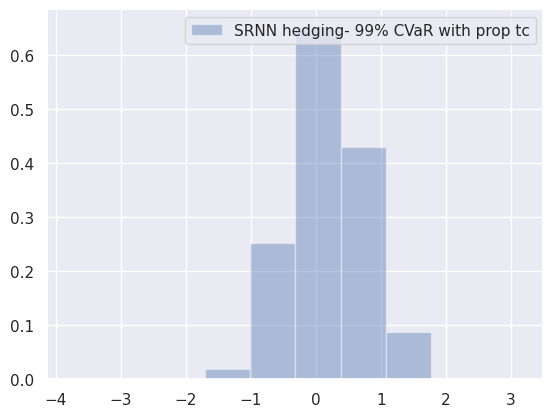

In [61]:
bins=50
fig, ax = plt.subplots()
ax.hist(pnl_hs_SRNN_CVaR_99_tc, density=True, alpha=0.4, label="SRNN hedging- 99% CVaR with prop tc")
ax.legend()
#plt.title("FFNN hedge with different criterion with transaction costs")
plt.show()

##### Model testing

In [79]:
# Data for training the neural network
heston_params["paths"] = int(2**12)
S1_test, S2_test, _ = Heston_pahts(**heston_params)
S1_test = S1_test.T
S2_test=S2_test.T
S1_test_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * S1_test
S2_test_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * S2_test

# on normalise (pour faciliter la descente de gradient) de façon en divisant tout par L = 200 (2*x0) 
L = 2*S0
data_size = paths
S1j_test_path = torch.from_numpy(S1_test_act).to(device).float().T / L
S2j_test_path = torch.from_numpy(S2_test_act).to(device).float().T / L
zj_test = torch.from_numpy(np.exp(-r*T)*np.maximum(S1_test[N]-K, 0))[:,None].to(device).float() / L

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 4282.38it/s]


In [80]:
with torch.no_grad():
  pnl_hs_SRNN_CVaR_99_tc_test= L*pnl_Heston_NN(S1j_test_path, S2j_test_path, zj_test, phi_SRNN_CVaR_99_tc,is_reccurent=is_reccurent,with_tc=with_tc,prop=prop,c=c).detach().numpy().flatten()

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x0 = pnl_hs_SRNN_CVaR_99_tc_test

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='SRNN hedging- 99% CVaR with prop tc on test data', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-5.0,
        end=5.0,
        size=0.1
    ),
    marker_color=list_of_colors[0] ,
    opacity= 0.75
))

fig.update_layout(
    width = 1000,
    height = 500,
    title_text='SRNN 99% CVaR with proportional costs on test data', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.05, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

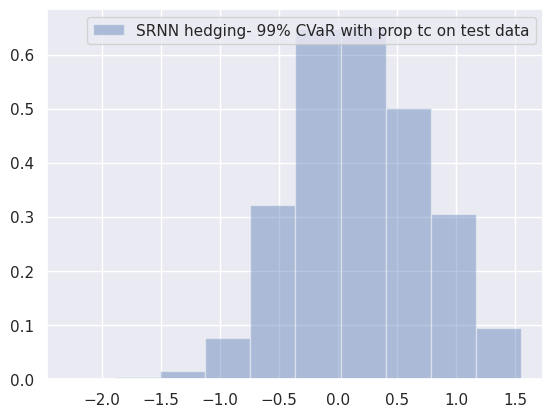

In [64]:
bins=50
fig, ax = plt.subplots()
ax.hist(pnl_hs_SRNN_CVaR_99_tc_test, density=True, alpha=0.4, label="SRNN hedging- 99% CVaR with prop tc on test data")
ax.legend()
#plt.title("FFNN hedge with different criterion with transaction costs")
plt.show()

#### FFNN VS SRNN 

<P style="color:red;font-size:30px;"><b>Warning: Do not run the following cell  </b></P>

In [ ]:
%%time
x0 = pnl_hs_SRNN_CVaR_99_tc_test
x1 = pnl_hs_FNN_CVaR_99_tc_test

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='SRNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-5.0,
        end=5.0,
        size=0.075
    ),
    marker_color=list_of_colors[0] ,
    opacity= 0.75
))

fig.add_trace(go.Histogram(
    x=x1,
    histnorm='percent',
    name='FFNN hedging- 99% CVaR', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-5.0,
        end=5.0,
        size=0.075
    ),
    marker_color=list_of_colors[1] ,
    opacity= 0.75
))

fig.update_layout(
    width = 1000,
    height = 500,
    title_text='Comparison of FFNN hedge and SRNN hedge with 99%-CVaR criterion with prop transaction costs: 0.01% on test dataset', # title of plot
    xaxis_title_text='PnL distribution', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.05, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

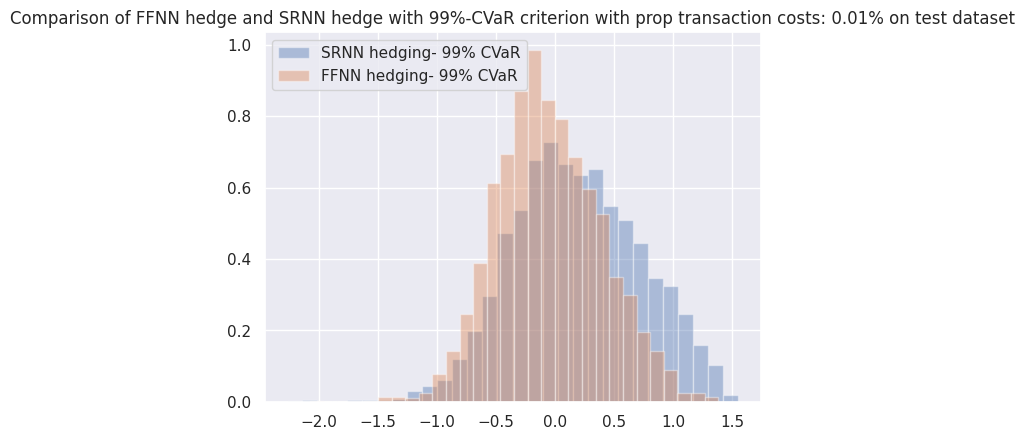

In [65]:
bins=30
fig, ax = plt.subplots()
ax.hist(pnl_hs_SRNN_CVaR_99_tc_test,bins=bins, density=True, alpha=0.4, label="SRNN hedging- 99% CVaR")
ax.hist(pnl_hs_FNN_CVaR_99_tc_test,bins=bins, density=True, alpha=0.4, label="FFNN hedging- 99% CVaR")
ax.legend()
plt.title("Comparison of FFNN hedge and SRNN hedge with 99%-CVaR criterion with prop transaction costs: 0.01% on test dataset")
plt.show()

In [82]:
print("=== Results for SRNN ===")
print("Realized 50 % CVaR:", pnl_hs_SRNN_CVaR_99_tc_test.mean())
print("Realized 99 % CVaR:", pnl_hs_SRNN_CVaR_99_tc_test.mean())
print("=== Results for FFNN ===")
print("Realized 50 % CVaR:", pnl_hs_FNN_CVaR_50_tc_test.mean())
print("Realized 99 % CVaR:", pnl_hs_FNN_CVaR_99_tc_test.mean())

=== Results for SRNN ===
Realized 50 % CVaR: 0.18408155
Realized 99 % CVaR: 0.18408155
=== Results for FFNN ===
Realized 50 % CVaR: -0.036030162
Realized 99 % CVaR: -0.05281584
